### Times series plotting - by day by un

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%matplotlib inline
#%matplotlib qt5
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt
import time

In [3]:
from Utils import TransantiagoConstants

In [4]:
DTPM_TRXDir = TransantiagoConstants.DTPM_TRXDir

##### Colors and others settings for plotting

In [5]:
colors = [(76, 181, 245),(183, 184, 182),(52, 103, 92),(179, 193, 0)]
for i in range(len(colors)):
    r, g, b = colors[i]  
    colors[i] = (r / 255., g / 255., b / 255.)

In [6]:
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fk' % (x*1e-3)

In [7]:
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(millions)

In [8]:
def reOrderingDataFrames(UN):
    summary = pd.DataFrame() 
    pn_input_path = os.path.join(DTPM_TRXDir, '2_DAILY_UN_SUMMARY/' + UN + '/' + UN + '_daily_pn_summary.csv')
    zp_input_path = os.path.join(DTPM_TRXDir, '2_DAILY_UN_SUMMARY/' + UN + '/' + UN + '_daily_zp_summary.csv')
    
    pn_summary = pd.read_csv(pn_input_path, sep=';', encoding = 'latin-1', index_col = 0)
    zp_summary = pd.read_csv(zp_input_path, sep=';', encoding = 'latin-1', index_col = 0)
    
    pn_summary['DATE'] = pn_summary['DATE'].apply(lambda x: pd.to_datetime(x).date())
    zp_summary['DATE'] = zp_summary['DATE'].apply(lambda x: pd.to_datetime(x).date())
    
    no_turnstile = pn_summary.loc[(pn_summary['torniquete_mariposa']==0)
                                  &(pn_summary['no_torniquete']==1),:]

    three_turnstile = pn_summary.loc[(pn_summary['torniquete_mariposa']==0)
                                     &(pn_summary['no_torniquete']==0),:]

    butterfly_turnstile = pn_summary.loc[(pn_summary['torniquete_mariposa']==1)
                                         &(pn_summary['no_torniquete']==0),:]
    
    summary = no_turnstile.loc[:,['YEAR_DAY', 'UN', 'YEAR', 'MONTH', 'SATURDAY', 'SUNDAY', 'DATE','pn_SUM_TRX', 'pn_SUM_EXP',
                                  'ratio', 'Buses', 'Estudiantes Ed. Media/Superior', 'm_ofertados', 'kms_ofertados',
                                  'Enero', 'Febrero', 'Julio', 'Nov_2017', 'Dic_2017','t', 'Feriado_laboral', 'Feriado_no_laboral',
                                  'Censo_Elecciones', 'Partido', 'FDS_Largo', 'Disturbios', 'Corte_Metro', 'Retraso_Metro',
                                  'Incidente_Metro', 'Bucle', 'Clima','visperas_laborales']]
    #First merge...
    three_turnstile = three_turnstile.merge(no_turnstile.loc[:,['YEAR','MONTH','YEAR_DAY']], how='outer', on = ['YEAR','MONTH','YEAR_DAY'])
    three_turnstile = three_turnstile.fillna(0)
    summary = summary.merge(three_turnstile.loc[:,['YEAR','MONTH','YEAR_DAY','pn_SUM_TRX','pn_SUM_EXP','ratio']], how='left', on=['YEAR','MONTH','YEAR_DAY'], suffixes=('_no_t','_3t'))
    
    #Second merge...
    butterfly_turnstile = butterfly_turnstile.merge(no_turnstile.loc[:,['YEAR','MONTH','YEAR_DAY']], how='outer', on = ['YEAR','MONTH','YEAR_DAY'])
    butterfly_turnstile = butterfly_turnstile.fillna(0)
    summary = summary.merge(butterfly_turnstile.loc[:,['YEAR','MONTH','YEAR_DAY','pn_SUM_TRX','pn_SUM_EXP','ratio']], how='left', on=['YEAR','MONTH','YEAR_DAY'])
    
    #Third merge...
    zp_summary = zp_summary.merge(no_turnstile.loc[:,['YEAR','MONTH','YEAR_DAY']], how='outer', on = ['YEAR','MONTH','YEAR_DAY'])
    zp_summary = zp_summary.fillna(0)
    summary = summary.merge(zp_summary.loc[:,['YEAR','MONTH','YEAR_DAY','zp_SUM_TRX','zp_SUM_TRX_NO_VALIDAS']], how='left', on=['YEAR','MONTH','YEAR_DAY'])
    
    #Renaming and final sorting...
    summary.rename(columns={"pn_SUM_TRX": "pn_SUM_TRX_tm", "pn_SUM_EXP": "pn_SUM_EXP_tm", "ratio":"ratio_tm"}, inplace=True)
    summary.sort_values(by=['YEAR','MONTH','YEAR_DAY'], ascending=[True, True, True], inplace=True)
    
    #Returning
    return summary

##### Plotting by UN

* Unidad 1

In [9]:
UN = 'U1'

summary_output_path = os.path.join(DTPM_TRXDir, '2_DAILY_UN_SUMMARY/' + UN + '/' + UN + '_summary.csv')

summary = reOrderingDataFrames(UN)

#summary.to_csv(summary_output_path, sep=";", encoding="latin-1")

In [10]:
len(summary.index)

1096

In [11]:
dates_values = summary['DATE'].values
no_turnstile_values = list(map(int, summary['pn_SUM_TRX_no_t'].values))
three_turnstile_values = list(map(int,summary['pn_SUM_TRX_3t'].values))
butterfly_turnstile_values = list(map(int,summary['pn_SUM_TRX_tm'].values))
zp_values = list(map(int,summary['zp_SUM_TRX'].values))
ratio_butterfly_turnstile_values = list(map(int,summary['ratio_tm'].values))

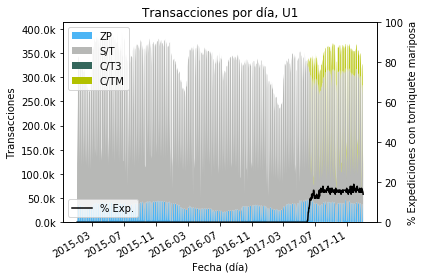

In [12]:
labels = ["ZP", "S/T", "C/T3", "C/TM"]
fig, ax = plt.subplots()
ax.stackplot(dates_values, zp_values, no_turnstile_values , three_turnstile_values , butterfly_turnstile_values , labels = labels , colors=colors)
ax.legend(loc=2)
ax.set_title('Transacciones por día, ' + UN)
ax.set_ylabel('Transacciones')
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('Fecha (día)')
fig.autofmt_xdate()

ax_1 = ax.twinx()
ax_1.plot(dates_values, ratio_butterfly_turnstile_values, color = 'black', label = '% Exp.')
ax_1.set_ylabel('% Expediciones con torniquete mariposa')
ax_1.legend(loc=3)
ax_1.set_ylim(0, 100)

plt.tight_layout()
#plt.xticks(np.arange(min(months_values), max(months_values)+1, 1.0))
#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/5_' + UN + 'trxOverTimeByDay_all.pdf')
plt.show()

In [13]:
import plotly.plotly
import plotly.graph_objs as go

trace1 = go.Bar(
    x=dates_values,
    y=zp_values,
    name='ZP',
    marker=dict(
        color='rgb(76, 181, 245)',
    ),
    opacity=0.6
)

trace2 = go.Bar(
    x=dates_values,
    y=no_turnstile_values,
    name='S/T',
    marker=dict(
        color='rgb(183, 184, 182)',
    ),
    opacity=0.6
)

trace3 = go.Bar(
    x=dates_values,
    y=three_turnstile_values,
    name='C/T3',
    marker=dict(
        color='rgb(52, 103, 92)',
    ),
    opacity=0.6    

)
trace4 = go.Bar(
    x=dates_values,
    y=butterfly_turnstile_values,
    name='C/TM',
    marker=dict(
        color='rgb(179, 193, 0)',
    ),
    opacity=0.6 
)

trace5 = go.Scatter(
    x = dates_values,
    y = ratio_butterfly_turnstile_values,
    yaxis='y2',
    name = '%Exp.C/TM',
    marker=dict(
        color='rgb(0, 0, 0)',
    ),
)


data = [trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
    title='Transacciones en bus y zona paga ' + UN +', 2015 a 2017',
    barmode='stack',
    yaxis=dict(
        title='Transacciones'
    ),
    yaxis2=dict(
        title='% exps. diarias C/TM',
        overlaying='y',
        side='right',
        range=[0, 100]
    )
)

fig = go.Figure(data=data, layout=layout)
#plotly.offline.plot(fig, filename='STACKED_' + UN + 'ALLDATESBYDATE')

* Unidad 3

In [14]:
UN = 'U3'

summary_output_path = os.path.join(DTPM_TRXDir, '2_DAILY_UN_SUMMARY/' + UN + '/' + UN + '_summary.csv')

summary = reOrderingDataFrames(UN)

#summary.to_csv(summary_output_path, sep=";", encoding="latin-1")

In [15]:
len(summary.index)

1096

In [16]:
dates_values = summary['DATE'].values
no_turnstile_values = list(map(int, summary['pn_SUM_TRX_no_t'].values))
three_turnstile_values = list(map(int,summary['pn_SUM_TRX_3t'].values))
butterfly_turnstile_values = list(map(int,summary['pn_SUM_TRX_tm'].values))
zp_values = list(map(int,summary['zp_SUM_TRX'].values))
ratio_butterfly_turnstile_values = list(map(int,summary['ratio_tm'].values))

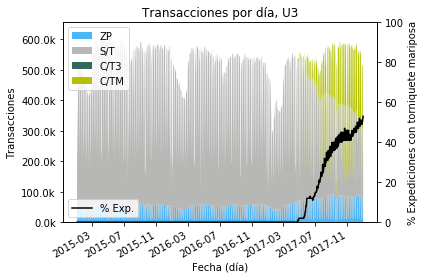

In [17]:
labels = ["ZP", "S/T", "C/T3", "C/TM"]
fig, ax = plt.subplots()
ax.stackplot(dates_values, zp_values, no_turnstile_values , three_turnstile_values , butterfly_turnstile_values , labels = labels , colors=colors)
ax.legend(loc=2)
ax.set_title('Transacciones por día, ' + UN)
ax.set_ylabel('Transacciones')
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('Fecha (día)')
fig.autofmt_xdate()

ax_1 = ax.twinx()
ax_1.plot(dates_values, ratio_butterfly_turnstile_values, color = 'black', label = '% Exp.')
ax_1.set_ylabel('% Expediciones con torniquete mariposa')
ax_1.legend(loc=3)
ax_1.set_ylim(0, 100)

plt.tight_layout()
#plt.xticks(np.arange(min(months_values), max(months_values)+1, 1.0))
#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/5_' + UN + 'trxOverTimeByDay_all.pdf')
plt.show()

In [18]:
trace1 = go.Bar(
    x=dates_values,
    y=zp_values,
    name='ZP',
    marker=dict(
        color='rgb(76, 181, 245)',
    ),
    opacity=0.6
)

trace2 = go.Bar(
    x=dates_values,
    y=no_turnstile_values,
    name='S/T',
    marker=dict(
        color='rgb(183, 184, 182)',
    ),
    opacity=0.6
)

trace3 = go.Bar(
    x=dates_values,
    y=three_turnstile_values,
    name='C/T3',
    marker=dict(
        color='rgb(52, 103, 92)',
    ),
    opacity=0.6    

)
trace4 = go.Bar(
    x=dates_values,
    y=butterfly_turnstile_values,
    name='C/TM',
    marker=dict(
        color='rgb(179, 193, 0)',
    ),
    opacity=0.6 
)

trace5 = go.Scatter(
    x = dates_values,
    y = ratio_butterfly_turnstile_values,
    yaxis='y2',
    name = '%Exp.C/TM',
    marker=dict(
        color='rgb(0, 0, 0)',
    ),
)


data = [trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
    title='Transacciones en bus y zona paga ' + UN +', 2015 a 2017',
    barmode='stack',
    yaxis=dict(
        title='Transacciones'
    ),
    yaxis2=dict(
        title='% exps. diarias C/TM',
        overlaying='y',
        side='right',
        range=[0, 100]
    )
)

fig = go.Figure(data=data, layout=layout)
#plotly.offline.plot(fig, filename='STACKED_' + UN + 'ALLDATESBYDATE')

* Unidad 4

In [19]:
UN = 'U4'

summary_output_path = os.path.join(DTPM_TRXDir, '2_DAILY_UN_SUMMARY/' + UN + '/' + UN + '_summary.csv')

summary = reOrderingDataFrames(UN)

#summary.to_csv(summary_output_path, sep=";", encoding="latin-1")

In [20]:
len(summary.index)

1096

In [21]:
dates_values = summary['DATE'].values
no_turnstile_values = list(map(int, summary['pn_SUM_TRX_no_t'].values))
three_turnstile_values = list(map(int,summary['pn_SUM_TRX_3t'].values))
butterfly_turnstile_values = list(map(int,summary['pn_SUM_TRX_tm'].values))
zp_values = list(map(int,summary['zp_SUM_TRX'].values))
ratio_butterfly_turnstile_values = list(map(int,summary['ratio_tm'].values))

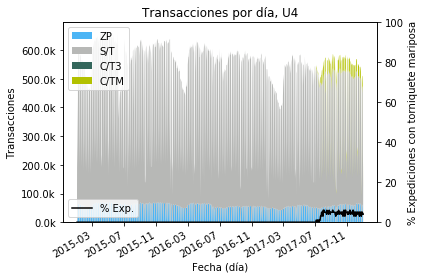

In [22]:
labels = ["ZP", "S/T", "C/T3", "C/TM"]
fig, ax = plt.subplots()
ax.stackplot(dates_values, zp_values, no_turnstile_values , three_turnstile_values , butterfly_turnstile_values , labels = labels , colors=colors)
ax.legend(loc=2)
ax.set_title('Transacciones por día, ' + UN)
ax.set_ylabel('Transacciones')
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('Fecha (día)')
fig.autofmt_xdate()

ax_1 = ax.twinx()
ax_1.plot(dates_values, ratio_butterfly_turnstile_values, color = 'black', label = '% Exp.')
ax_1.set_ylabel('% Expediciones con torniquete mariposa')
ax_1.legend(loc=3)
ax_1.set_ylim(0, 100)

plt.tight_layout()
#plt.xticks(np.arange(min(months_values), max(months_values)+1, 1.0))
#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/5_' + UN + 'trxOverTimeByDay_all.pdf')
plt.show()

In [23]:
trace1 = go.Bar(
    x=dates_values,
    y=zp_values,
    name='ZP',
    marker=dict(
        color='rgb(76, 181, 245)',
    ),
    opacity=0.6
)

trace2 = go.Bar(
    x=dates_values,
    y=no_turnstile_values,
    name='S/T',
    marker=dict(
        color='rgb(183, 184, 182)',
    ),
    opacity=0.6
)

trace3 = go.Bar(
    x=dates_values,
    y=three_turnstile_values,
    name='C/T3',
    marker=dict(
        color='rgb(52, 103, 92)',
    ),
    opacity=0.6    

)
trace4 = go.Bar(
    x=dates_values,
    y=butterfly_turnstile_values,
    name='C/TM',
    marker=dict(
        color='rgb(179, 193, 0)',
    ),
    opacity=0.6 
)

trace5 = go.Scatter(
    x = dates_values,
    y = ratio_butterfly_turnstile_values,
    yaxis='y2',
    name = '%Exp.C/TM',
    marker=dict(
        color='rgb(0, 0, 0)',
    ),
)


data = [trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
    title='Transacciones en bus y zona paga ' + UN +', 2015 a 2017',
    barmode='stack',
    yaxis=dict(
        title='Transacciones'
    ),
    yaxis2=dict(
        title='% exps. diarias C/TM',
        overlaying='y',
        side='right',
        range=[0, 100]
    )
)

fig = go.Figure(data=data, layout=layout)
#plotly.offline.plot(fig, filename='STACKED_' + UN + 'ALLDATESBYDATE')

* Unidad 5

In [24]:
UN = 'U5'

summary_output_path = os.path.join(DTPM_TRXDir, '2_DAILY_UN_SUMMARY/' + UN + '/' + UN + '_summary.csv')

summary = reOrderingDataFrames(UN)

#summary.to_csv(summary_output_path, sep=";", encoding="latin-1")

In [25]:
len(summary.index)

1096

In [26]:
dates_values = summary['DATE'].values
no_turnstile_values = list(map(int, summary['pn_SUM_TRX_no_t'].values))
three_turnstile_values = list(map(int,summary['pn_SUM_TRX_3t'].values))
butterfly_turnstile_values = list(map(int,summary['pn_SUM_TRX_tm'].values))
zp_values = list(map(int,summary['zp_SUM_TRX'].values))
ratio_butterfly_turnstile_values = list(map(int,summary['ratio_tm'].values))

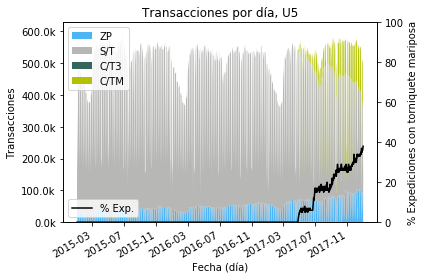

In [27]:
labels = ["ZP", "S/T", "C/T3", "C/TM"]
fig, ax = plt.subplots()
ax.stackplot(dates_values, zp_values, no_turnstile_values , three_turnstile_values , butterfly_turnstile_values , labels = labels , colors=colors)
ax.legend(loc=2)
ax.set_title('Transacciones por día, ' + UN)
ax.set_ylabel('Transacciones')
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('Fecha (día)')
fig.autofmt_xdate()

ax_1 = ax.twinx()
ax_1.plot(dates_values, ratio_butterfly_turnstile_values, color = 'black', label = '% Exp.')
ax_1.set_ylabel('% Expediciones con torniquete mariposa')
ax_1.legend(loc=3)
ax_1.set_ylim(0, 100)

plt.tight_layout()
#plt.xticks(np.arange(min(months_values), max(months_values)+1, 1.0))
#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/5_' + UN + 'trxOverTimeByDay_all.pdf')
plt.show()

In [28]:
trace1 = go.Bar(
    x=dates_values,
    y=zp_values,
    name='ZP',
    marker=dict(
        color='rgb(76, 181, 245)',
    ),
    opacity=0.6
)

trace2 = go.Bar(
    x=dates_values,
    y=no_turnstile_values,
    name='S/T',
    marker=dict(
        color='rgb(183, 184, 182)',
    ),
    opacity=0.6
)

trace3 = go.Bar(
    x=dates_values,
    y=three_turnstile_values,
    name='C/T3',
    marker=dict(
        color='rgb(52, 103, 92)',
    ),
    opacity=0.6    

)
trace4 = go.Bar(
    x=dates_values,
    y=butterfly_turnstile_values,
    name='C/TM',
    marker=dict(
        color='rgb(179, 193, 0)',
    ),
    opacity=0.6 
)

trace5 = go.Scatter(
    x = dates_values,
    y = ratio_butterfly_turnstile_values,
    yaxis='y2',
    name = '%Exp.C/TM',
    marker=dict(
        color='rgb(0, 0, 0)',
    ),
)


data = [trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
    title='Transacciones en bus y zona paga ' + UN +', 2015 a 2017',
    barmode='stack',
    yaxis=dict(
        title='Transacciones'
    ),
    yaxis2=dict(
        title='% exps. diarias C/TM',
        overlaying='y',
        side='right',
        range=[0, 100]
    )
)

fig = go.Figure(data=data, layout=layout)
#plotly.offline.plot(fig, filename='STACKED_' + UN + 'ALLDATESBYDATE')

* Unidad 6

In [29]:
UN = 'U6'

summary_output_path = os.path.join(DTPM_TRXDir, '2_DAILY_UN_SUMMARY/' + UN + '/' + UN + '_summary.csv')

summary = reOrderingDataFrames(UN)

#summary.to_csv(summary_output_path, sep=";", encoding="latin-1")

In [30]:
len(summary.index)

1096

In [31]:
dates_values = summary['DATE'].values
no_turnstile_values = list(map(int, summary['pn_SUM_TRX_no_t'].values))
three_turnstile_values = list(map(int,summary['pn_SUM_TRX_3t'].values))
butterfly_turnstile_values = list(map(int,summary['pn_SUM_TRX_tm'].values))
zp_values = list(map(int,summary['zp_SUM_TRX'].values))
ratio_butterfly_turnstile_values = list(map(int,summary['ratio_tm'].values))

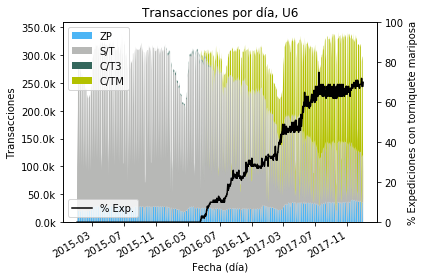

In [32]:
labels = ["ZP", "S/T", "C/T3", "C/TM"]
fig, ax = plt.subplots()
ax.stackplot(dates_values, zp_values, no_turnstile_values , three_turnstile_values , butterfly_turnstile_values , labels = labels , colors=colors)
ax.legend(loc=2)
ax.set_title('Transacciones por día, ' + UN)
ax.set_ylabel('Transacciones')
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('Fecha (día)')
fig.autofmt_xdate()

ax_1 = ax.twinx()
ax_1.plot(dates_values, ratio_butterfly_turnstile_values, color = 'black', label = '% Exp.')
ax_1.set_ylabel('% Expediciones con torniquete mariposa')
ax_1.legend(loc=3)
ax_1.set_ylim(0, 100)

plt.tight_layout()
#plt.xticks(np.arange(min(months_values), max(months_values)+1, 1.0))
#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/5_' + UN + 'trxOverTimeByDay_all.pdf')
plt.show()

In [33]:
trace1 = go.Bar(
    x=dates_values,
    y=zp_values,
    name='ZP',
    marker=dict(
        color='rgb(76, 181, 245)',
    ),
    opacity=0.6
)

trace2 = go.Bar(
    x=dates_values,
    y=no_turnstile_values,
    name='S/T',
    marker=dict(
        color='rgb(183, 184, 182)',
    ),
    opacity=0.6
)

trace3 = go.Bar(
    x=dates_values,
    y=three_turnstile_values,
    name='C/T3',
    marker=dict(
        color='rgb(52, 103, 92)',
    ),
    opacity=0.6    

)
trace4 = go.Bar(
    x=dates_values,
    y=butterfly_turnstile_values,
    name='C/TM',
    marker=dict(
        color='rgb(179, 193, 0)',
    ),
    opacity=0.6 
)

trace5 = go.Scatter(
    x = dates_values,
    y = ratio_butterfly_turnstile_values,
    yaxis='y2',
    name = '%Exp.C/TM',
    marker=dict(
        color='rgb(0, 0, 0)',
    ),
)


data = [trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
    title='Transacciones en bus y zona paga ' + UN +', 2015 a 2017',
    barmode='stack',
    yaxis=dict(
        title='Transacciones'
    ),
    yaxis2=dict(
        title='% exps. diarias C/TM',
        overlaying='y',
        side='right',
        range=[0, 100]
    )
)

fig = go.Figure(data=data, layout=layout)
#plotly.offline.plot(fig, filename='STACKED_' + UN + 'ALLDATESBYDATE')

* Unidad 7

In [34]:
UN = 'U7'

summary_output_path = os.path.join(DTPM_TRXDir, '2_DAILY_UN_SUMMARY/' + UN + '/' + UN + '_summary.csv')

summary = reOrderingDataFrames(UN)

#summary.to_csv(summary_output_path, sep=";", encoding="latin-1")

In [35]:
len(summary.index)

1096

In [36]:
dates_values = summary['DATE'].values
no_turnstile_values = list(map(int, summary['pn_SUM_TRX_no_t'].values))
three_turnstile_values = list(map(int,summary['pn_SUM_TRX_3t'].values))
butterfly_turnstile_values = list(map(int,summary['pn_SUM_TRX_tm'].values))
zp_values = list(map(int,summary['zp_SUM_TRX'].values))
ratio_butterfly_turnstile_values = list(map(int,summary['ratio_tm'].values))

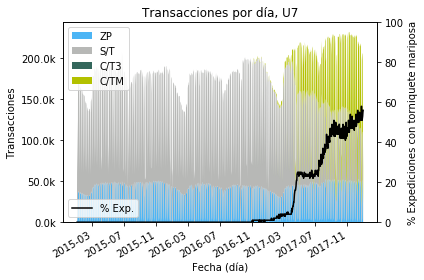

In [37]:
labels = ["ZP", "S/T", "C/T3", "C/TM"]
fig, ax = plt.subplots()
ax.stackplot(dates_values, zp_values, no_turnstile_values , three_turnstile_values , butterfly_turnstile_values , labels = labels , colors=colors)
ax.legend(loc=2)
ax.set_title('Transacciones por día, ' + UN)
ax.set_ylabel('Transacciones')
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('Fecha (día)')
fig.autofmt_xdate()

ax_1 = ax.twinx()
ax_1.plot(dates_values, ratio_butterfly_turnstile_values, color = 'black', label = '% Exp.')
ax_1.set_ylabel('% Expediciones con torniquete mariposa')
ax_1.legend(loc=3)
ax_1.set_ylim(0, 100)

plt.tight_layout()
#plt.xticks(np.arange(min(months_values), max(months_values)+1, 1.0))
#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/5_' + UN + 'trxOverTimeByDay_all.pdf')
plt.show()

In [38]:
trace1 = go.Bar(
    x=dates_values,
    y=zp_values,
    name='ZP',
    marker=dict(
        color='rgb(76, 181, 245)',
    ),
    opacity=0.6
)

trace2 = go.Bar(
    x=dates_values,
    y=no_turnstile_values,
    name='S/T',
    marker=dict(
        color='rgb(183, 184, 182)',
    ),
    opacity=0.6
)

trace3 = go.Bar(
    x=dates_values,
    y=three_turnstile_values,
    name='C/T3',
    marker=dict(
        color='rgb(52, 103, 92)',
    ),
    opacity=0.6    

)
trace4 = go.Bar(
    x=dates_values,
    y=butterfly_turnstile_values,
    name='C/TM',
    marker=dict(
        color='rgb(179, 193, 0)',
    ),
    opacity=0.6 
)

trace5 = go.Scatter(
    x = dates_values,
    y = ratio_butterfly_turnstile_values,
    yaxis='y2',
    name = '%Exp.C/TM',
    marker=dict(
        color='rgb(0, 0, 0)',
    ),
)


data = [trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
    title='Transacciones en bus y zona paga ' + UN +', 2015 a 2017',
    barmode='stack',
    yaxis=dict(
        title='Transacciones'
    ),
    yaxis2=dict(
        title='% exps. diarias C/TM',
        overlaying='y',
        side='right',
        range=[0, 100]
    )
)

fig = go.Figure(data=data, layout=layout)
#plotly.offline.plot(fig, filename='STACKED_' + UN + 'ALLDATESBYDATE')

* Special case: Unidad 2... Processing is made manually

In [39]:
    UN='U2'
    summary = pd.DataFrame() 
    pn_input_path = os.path.join(DTPM_TRXDir, '2_DAILY_UN_SUMMARY/' + UN + '/' + UN + '_daily_pn_summary.csv')
    zp_input_path = os.path.join(DTPM_TRXDir, '2_DAILY_UN_SUMMARY/' + UN + '/' + UN + '_daily_zp_summary.csv')
    
    pn_summary = pd.read_csv(pn_input_path, sep=';', encoding = 'latin-1', index_col = 0)
    zp_summary = pd.read_csv(zp_input_path, sep=';', encoding = 'latin-1', index_col = 0)
    
    pn_summary['DATE'] = pn_summary['DATE'].apply(lambda x: pd.to_datetime(x).date())
    zp_summary['DATE'] = zp_summary['DATE'].apply(lambda x: pd.to_datetime(x).date())
    
    no_turnstile = pn_summary.loc[(pn_summary['torniquete_mariposa']==0)
                                  &(pn_summary['no_torniquete']==1),:]

    three_turnstile = pn_summary.loc[(pn_summary['torniquete_mariposa']==0)
                                     &(pn_summary['no_torniquete']==0),:]

    butterfly_turnstile = pn_summary.loc[(pn_summary['torniquete_mariposa']==1)
                                         &(pn_summary['no_torniquete']==0),:]
    
    summary = three_turnstile.loc[:,['YEAR_DAY', 'UN', 'YEAR', 'MONTH', 'SATURDAY', 'SUNDAY', 'DATE','pn_SUM_TRX', 'pn_SUM_EXP',
                                  'ratio', 'Buses', 'Estudiantes Ed. Media/Superior', 'm_ofertados', 'kms_ofertados',
                                  'Enero', 'Febrero', 'Julio', 'Nov_2017', 'Dic_2017','t', 'Feriado_laboral', 'Feriado_no_laboral',
                                  'Censo_Elecciones', 'Partido', 'FDS_Largo', 'Disturbios', 'Corte_Metro', 'Retraso_Metro',
                                  'Incidente_Metro', 'Bucle', 'Clima','visperas_laborales']]
    #First merge...
    no_turnstile = no_turnstile.merge(three_turnstile.loc[:,['YEAR','MONTH','YEAR_DAY']], how='outer', on = ['YEAR','MONTH','YEAR_DAY'])
    no_turnstile = no_turnstile.fillna(0)
    summary = summary.merge(no_turnstile.loc[:,['YEAR','MONTH','YEAR_DAY','pn_SUM_TRX','pn_SUM_EXP','ratio']], how='left', on=['YEAR','MONTH','YEAR_DAY'], suffixes=('_3t','_no_t'))
    
    #Second merge...
    butterfly_turnstile = butterfly_turnstile.merge(three_turnstile.loc[:,['YEAR','MONTH','YEAR_DAY']], how='outer', on = ['YEAR','MONTH','YEAR_DAY'])
    butterfly_turnstile = butterfly_turnstile.fillna(0)
    summary = summary.merge(butterfly_turnstile.loc[:,['YEAR','MONTH','YEAR_DAY','pn_SUM_TRX','pn_SUM_EXP','ratio']], how='left', on=['YEAR','MONTH','YEAR_DAY'])
    
    #Third merge...
    zp_summary = zp_summary.merge(three_turnstile.loc[:,['YEAR','MONTH','YEAR_DAY']], how='outer', on = ['YEAR','MONTH','YEAR_DAY'])
    zp_summary = zp_summary.fillna(0)
    summary = summary.merge(zp_summary.loc[:,['YEAR','MONTH','YEAR_DAY','zp_SUM_TRX','zp_SUM_TRX_NO_VALIDAS']], how='left', on=['YEAR','MONTH','YEAR_DAY'])
    
    #Renaming and final sorting...
    summary.rename(columns={"pn_SUM_TRX": "pn_SUM_TRX_tm", "pn_SUM_EXP": "pn_SUM_EXP_tm", "ratio":"ratio_tm"}, inplace=True)
    summary.sort_values(by=['YEAR','MONTH','YEAR_DAY'], ascending=[True, True, True], inplace=True)


In [40]:
len(summary.index)

1096

In [41]:
summary_output_path = os.path.join(DTPM_TRXDir, '2_DAILY_UN_SUMMARY/' + UN + '/' + UN + '_summary.csv')

#summary.to_csv(summary_output_path, sep=";", encoding="latin-1")

In [42]:
dates_values = summary['DATE'].values
no_turnstile_values = list(map(int, summary['pn_SUM_TRX_no_t'].values))
three_turnstile_values = list(map(int,summary['pn_SUM_TRX_3t'].values))
butterfly_turnstile_values = list(map(int,summary['pn_SUM_TRX_tm'].values))
zp_values = list(map(int,summary['zp_SUM_TRX'].values))
ratio_butterfly_turnstile_values = list(map(int,summary['ratio_tm'].values))

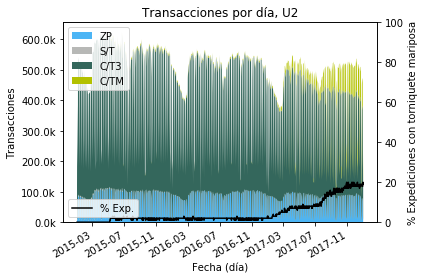

In [43]:
labels = ["ZP", "S/T", "C/T3", "C/TM"]
fig, ax = plt.subplots()
ax.stackplot(dates_values, zp_values, no_turnstile_values , three_turnstile_values , butterfly_turnstile_values , labels = labels , colors=colors)
ax.legend(loc=2)
ax.set_title('Transacciones por día, ' + UN)
ax.set_ylabel('Transacciones')
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('Fecha (día)')
fig.autofmt_xdate()

ax_1 = ax.twinx()
ax_1.plot(dates_values, ratio_butterfly_turnstile_values, color = 'black', label = '% Exp.')
ax_1.set_ylabel('% Expediciones con torniquete mariposa')
ax_1.legend(loc=3)
ax_1.set_ylim(0, 100)

plt.tight_layout()
#plt.xticks(np.arange(min(months_values), max(months_values)+1, 1.0))
#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/5_' + UN + 'trxOverTimeByDay_all.pdf')
plt.show()

In [44]:
trace1 = go.Bar(
    x=dates_values,
    y=zp_values,
    name='ZP',
    marker=dict(
        color='rgb(76, 181, 245)',
    ),
    opacity=0.6
)

trace2 = go.Bar(
    x=dates_values,
    y=no_turnstile_values,
    name='S/T',
    marker=dict(
        color='rgb(183, 184, 182)',
    ),
    opacity=0.6
)

trace3 = go.Bar(
    x=dates_values,
    y=three_turnstile_values,
    name='C/T3',
    marker=dict(
        color='rgb(52, 103, 92)',
    ),
    opacity=0.6    

)
trace4 = go.Bar(
    x=dates_values,
    y=butterfly_turnstile_values,
    name='C/TM',
    marker=dict(
        color='rgb(179, 193, 0)',
    ),
    opacity=0.6 
)

trace5 = go.Scatter(
    x = dates_values,
    y = ratio_butterfly_turnstile_values,
    yaxis='y2',
    name = '%Exp.C/TM',
    marker=dict(
        color='rgb(0, 0, 0)',
    ),
)


data = [trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
    title='Transacciones en bus y zona paga ' + UN +', 2015 a 2017',
    barmode='stack',
    yaxis=dict(
        title='Transacciones'
    ),
    yaxis2=dict(
        title='% exps. diarias C/TM',
        overlaying='y',
        side='right',
        range=[0, 100]
    )
)

fig = go.Figure(data=data, layout=layout)
#plotly.offline.plot(fig, filename='STACKED_' + UN + 'ALLDATESBYDATE')

## Closed